In [1]:
import hydra
from omegaconf import DictConfig
import logging
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.models import resnet18, resnet34
from models import SimCLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import umap

/home/sp645/miniconda3/envs/ffcv-ssl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


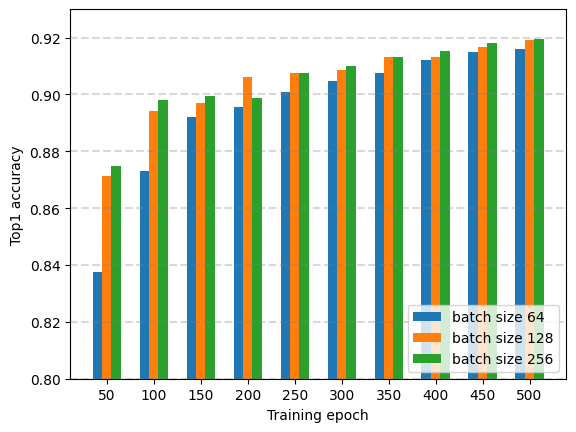

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace this with your actual data)
categories = ['50', '100', '150', '200', '250', '300', '350', '400', '450', '500']
array3 = [0.8748, 0.8979, 0.8994, 0.8989, 0.9075, 0.9100, 0.9130, 0.9152, 0.9141, 0.9156]
array2 = [0.8714, 0.8940, 0.8969, 0.9060, 0.9074, 0.9085, 0.9132, 0.9130, 0.9146, 0.9153]
array1 = [0.8376, 0.8731, 0.8921, 0.8954, 0.9010, 0.9047, 0.9075, 0.9121, 0.9140, 0.9150] 

# Bar width
bar_width = 0.2
for y in np.arange(0.8, 0.94, 0.02):
    plt.axhline(y, color='gray', linestyle='--', alpha=0.3)

# Set up positions for three bars for each category
positions = np.arange(len(categories))
bar1_positions = positions - bar_width
bar2_positions = positions
bar3_positions = positions + bar_width

# Create the bar plot
plt.bar(bar1_positions, array1, width=bar_width, label='batch size 64')
plt.bar(bar2_positions, array2, width=bar_width, label='batch size 128')
plt.bar(bar3_positions, array3, width=bar_width, label='batch size 256')

# Set labels and title
plt.xlabel('Training epoch')
plt.ylabel('Top1 accuracy')
plt.xticks(positions, categories)
plt.ylim(0.8, 0.93)
plt.legend(loc='lower right')
# Show the plot
plt.savefig('barplot.svg')
plt.savefig('barplot.pdf')
plt.show()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(32),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.ToTensor()])
test_transform = transforms.ToTensor()
test_set = CIFAR10(root='./data', train=False, transform=test_transform, download=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [4]:
enc_path = './logs/SimCLR/cifar10/simclr_resnet18_epoch50_batch64.pt'
proj_path = './logs/SimCLR/cifar10/simclr_resnet18_epoch50_batch64.pt'
base_encoder = eval('resnet18')
model = SimCLR(base_encoder, projection_dim=128).cuda()
#pre_model.load_state_dict(torch.load('./logs/SimCLR/cifar10/simclr_{}_epoch{}_batch{}.pt'.format('resnet18', epoch_size, batch_size)))
saved_enc_dict = torch.load(enc_path)
# saved_proj_dict = torch.load(enc_path)
# model.enc.load_state_dict(saved_enc_dict)
# model.proj.load_state_dict(proj_path)
# model = model.to(device)
model.load_state_dict(enc_path)
label_list = []
output_list = []
model.eval()
for (inputs, labels) in test_loader:
    label_list.append(labels)
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    print(outputs.shape)
    output_list.append(outputs)


/home/sp645/miniconda3/envs/ffcv-ssl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sp645/miniconda3/envs/ffcv-ssl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var". 
	Unexpected key(s) in state_dict: "enc.conv1.weight", "enc.bn1.weight", "enc.bn1.bias", "enc.bn1.running_mean", "enc.bn1.running_var", "enc.bn1.num_batches_tracked", "enc.layer1.0.conv1.weight", "enc.layer1.0.bn1.weight", "enc.layer1.0.bn1.bias", "enc.layer1.0.bn1.running_mean", "enc.layer1.0.bn1.running_var", "enc.layer1.0.bn1.num_batches_tracked", "enc.layer1.0.conv2.weight", "enc.layer1.0.bn2.weight", "enc.layer1.0.bn2.bias", "enc.layer1.0.bn2.running_mean", "enc.layer1.0.bn2.running_var", "enc.layer1.0.bn2.num_batches_tracked", "enc.layer1.1.conv1.weight", "enc.layer1.1.bn1.weight", "enc.layer1.1.bn1.bias", "enc.layer1.1.bn1.running_mean", "enc.layer1.1.bn1.running_var", "enc.layer1.1.bn1.num_batches_tracked", "enc.layer1.1.conv2.weight", "enc.layer1.1.bn2.weight", "enc.layer1.1.bn2.bias", "enc.layer1.1.bn2.running_mean", "enc.layer1.1.bn2.running_var", "enc.layer1.1.bn2.num_batches_tracked", "enc.layer2.0.conv1.weight", "enc.layer2.0.bn1.weight", "enc.layer2.0.bn1.bias", "enc.layer2.0.bn1.running_mean", "enc.layer2.0.bn1.running_var", "enc.layer2.0.bn1.num_batches_tracked", "enc.layer2.0.conv2.weight", "enc.layer2.0.bn2.weight", "enc.layer2.0.bn2.bias", "enc.layer2.0.bn2.running_mean", "enc.layer2.0.bn2.running_var", "enc.layer2.0.bn2.num_batches_tracked", "enc.layer2.0.downsample.0.weight", "enc.layer2.0.downsample.1.weight", "enc.layer2.0.downsample.1.bias", "enc.layer2.0.downsample.1.running_mean", "enc.layer2.0.downsample.1.running_var", "enc.layer2.0.downsample.1.num_batches_tracked", "enc.layer2.1.conv1.weight", "enc.layer2.1.bn1.weight", "enc.layer2.1.bn1.bias", "enc.layer2.1.bn1.running_mean", "enc.layer2.1.bn1.running_var", "enc.layer2.1.bn1.num_batches_tracked", "enc.layer2.1.conv2.weight", "enc.layer2.1.bn2.weight", "enc.layer2.1.bn2.bias", "enc.layer2.1.bn2.running_mean", "enc.layer2.1.bn2.running_var", "enc.layer2.1.bn2.num_batches_tracked", "enc.layer3.0.conv1.weight", "enc.layer3.0.bn1.weight", "enc.layer3.0.bn1.bias", "enc.layer3.0.bn1.running_mean", "enc.layer3.0.bn1.running_var", "enc.layer3.0.bn1.num_batches_tracked", "enc.layer3.0.conv2.weight", "enc.layer3.0.bn2.weight", "enc.layer3.0.bn2.bias", "enc.layer3.0.bn2.running_mean", "enc.layer3.0.bn2.running_var", "enc.layer3.0.bn2.num_batches_tracked", "enc.layer3.0.downsample.0.weight", "enc.layer3.0.downsample.1.weight", "enc.layer3.0.downsample.1.bias", "enc.layer3.0.downsample.1.running_mean", "enc.layer3.0.downsample.1.running_var", "enc.layer3.0.downsample.1.num_batches_tracked", "enc.layer3.1.conv1.weight", "enc.layer3.1.bn1.weight", "enc.layer3.1.bn1.bias", "enc.layer3.1.bn1.running_mean", "enc.layer3.1.bn1.running_var", "enc.layer3.1.bn1.num_batches_tracked", "enc.layer3.1.conv2.weight", "enc.layer3.1.bn2.weight", "enc.layer3.1.bn2.bias", "enc.layer3.1.bn2.running_mean", "enc.layer3.1.bn2.running_var", "enc.layer3.1.bn2.num_batches_tracked", "enc.layer4.0.conv1.weight", "enc.layer4.0.bn1.weight", "enc.layer4.0.bn1.bias", "enc.layer4.0.bn1.running_mean", "enc.layer4.0.bn1.running_var", "enc.layer4.0.bn1.num_batches_tracked", "enc.layer4.0.conv2.weight", "enc.layer4.0.bn2.weight", "enc.layer4.0.bn2.bias", "enc.layer4.0.bn2.running_mean", "enc.layer4.0.bn2.running_var", "enc.layer4.0.bn2.num_batches_tracked", "enc.layer4.0.downsample.0.weight", "enc.layer4.0.downsample.1.weight", "enc.layer4.0.downsample.1.bias", "enc.layer4.0.downsample.1.running_mean", "enc.layer4.0.downsample.1.running_var", "enc.layer4.0.downsample.1.num_batches_tracked", "enc.layer4.1.conv1.weight", "enc.layer4.1.bn1.weight", "enc.layer4.1.bn1.bias", "enc.layer4.1.bn1.running_mean", "enc.layer4.1.bn1.running_var", "enc.layer4.1.bn1.num_batches_tracked", "enc.layer4.1.conv2.weight", "enc.layer4.1.bn2.weight", "enc.layer4.1.bn2.bias", "enc.layer4.1.bn2.running_mean", "enc.layer4.1.bn2.running_var", "enc.layer4.1.bn2.num_batches_tracked", "projector.0.weight", "projector.0.bias", "projector.2.weight", "projector.2.bias". 